# About Dataset

## Source
https://www.kaggle.com/datasets/camnugent/california-housing-prices

## Context
This is the dataset used in the second chapter of Aurélien Géron's recent book 'Hands-On Machine learning with Scikit-Learn and TensorFlow'. It serves as an excellent introduction to implementing machine learning algorithms because it requires rudimentary data cleaning, has an easily understandable list of variables and sits at an optimal size between being to toyish and too cumbersome.

The data contains information from the 1990 California census. So although it may not help you with predicting current housing prices like the Zillow Zestimate dataset, it does provide an accessible introductory dataset for teaching people about the basics of machine learning.

## Content
The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data. Be warned the data aren't cleaned so there are some preprocessing steps required! The columns are as follows, their names are pretty self explanitory:

1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea

## Objective

Answer two business questions

- as younger the housingMedianAge, bigger the medianHousevalue?

- as bigger the medianIncome, bigger the medianHousevalue?

Get a better prediction than the book 'Hands-On Machine learning with Scikit-Learn and TensorFlow', the tuned model with the train set get a RMSE: 49.682 and the final evaluation was 47.730,2 for the test set. The strategy is try different methods os scaling, hyperparameters, algorithms and try eliminate some features

# 1.0 IMPORTS

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from yellowbrick.model_selection import RFECV, LearningCurve
import scipy

## 1.1 Functions

In [2]:
def barplot(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limits(coluna))
    ax.grid(False)
    
def limits(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def boxplot(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limits(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def exclude_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limits(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas
    
def display_scores(model_name, scores):
    RMSE = scores
    mean = scores.mean()
    std = scores.std()
    dicionario = {'Model': model_name, 'Mean RMSE': mean, 'Standard deviation':std}
    return dicionario

## 1.2 Download data

In [3]:
#collecting data
df_original = pd.read_csv('housing.csv')
df_original.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 2.0 Data descriptions

In [4]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The feature 'total_bedrooms' has some NA values, we are going to have to treat this later. Beyond that, we can see that 'ocean_proximity' it's a object type, so it will be necessary to transform this feature with a encode method.

In [5]:
df_original.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


median_income is in another scale than we expect. The real values are multiplied by 10000

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

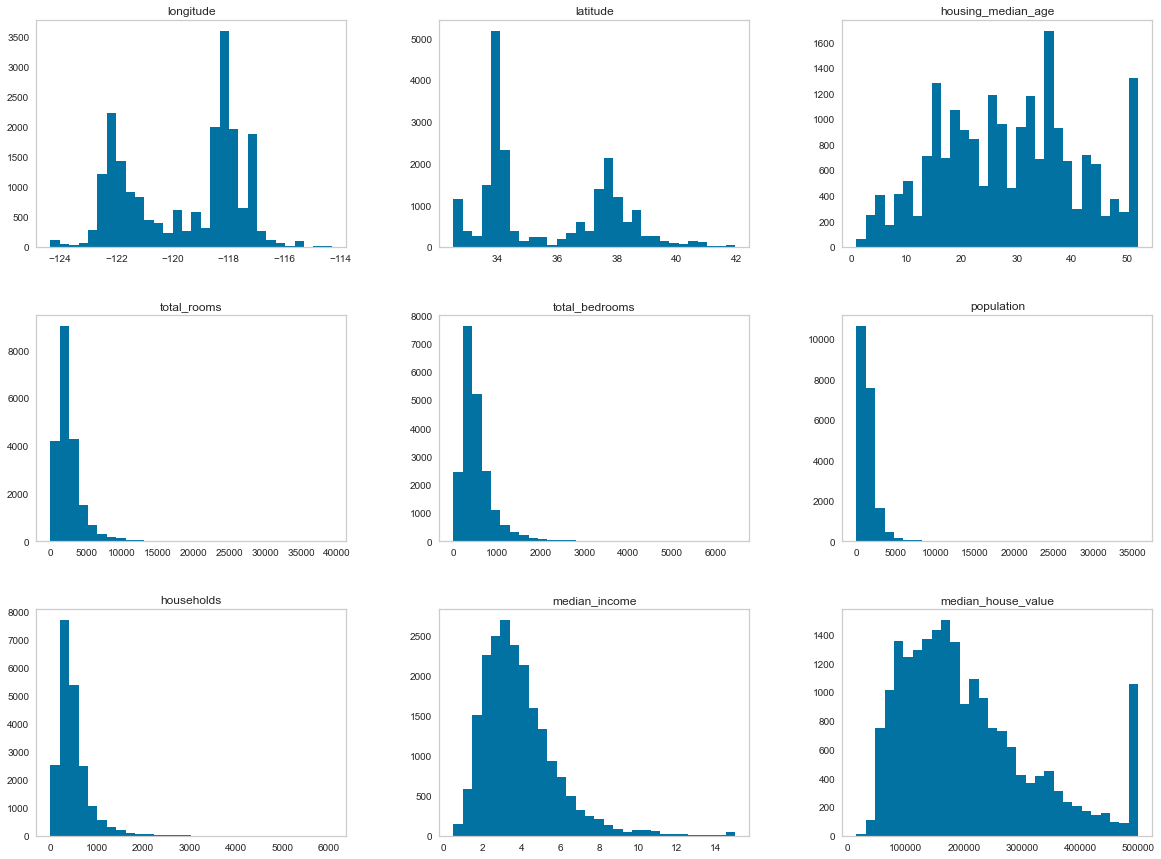

In [6]:
df_original.hist(bins = 30, figsize=(20,15), grid = False)

# 3.0 Split train and test set

In [7]:
df1 = df_original.copy()

In [8]:
# change some variables to not have unexpected characteres
df1.loc[df1['ocean_proximity']=='<1H OCEAN', 'ocean_proximity'] = '1H_OCEAN'
df1.loc[df1['ocean_proximity']=='NEAR BAY', 'ocean_proximity'] = 'NEAR_BAY'
df1.loc[df1['ocean_proximity']=='NEAR OCEAN', 'ocean_proximity'] = 'NEAR_OCEAN'

Following the example of the book tha we based on, the "median_income" has been told, by experts of the business,that it is the most important feature, we can check that later, but for now lets assume that. To avoid a sampling bias in the test set over the data set, when we separate in train and test set, we create a new collumn to auxiliate that stratification and maintain the proportion.

In this technic, we create a new column grouping the values distributed in the bins and adding a label to identify each group.

In [9]:
#create new collumn
df1['income_cat'] = pd.cut(df1['median_income'], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5])
df1[['median_income','income_cat']].head()

,median_income,income_cat
0,8.3252,5
1,8.3014,5
2,7.2574,5
3,5.6431,4
4,3.8462,3


The method StratifiedShuffleSplit allow us to split the dataset based on some conditional, in this case the feature "median_income". That is a good method if we want guarantee that the test set proportion is similar to the all dataset and avoid a sampling bias.

In [10]:
#separate the train and test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df1,df1['income_cat']):
    strat_train_set = df1.loc[train_index]
    strat_test_set  = df1.loc[test_index]

print(strat_test_set['income_cat'].value_counts()/len(strat_test_set))

print(strat_test_set['income_cat'].value_counts())

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64
3    1447
2    1316
4     728
5     472
1     165
Name: income_cat, dtype: int64


In [11]:
#remove the income_cat
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

# 4.0 Feature engineering

In [102]:
df_train = strat_train_set.copy()

The book suggest the creation of some features. Analysing the original features: rooms, bedrooms, population. Looking at them in a isolate form they seem to not tell us much, mainly because it´s not only the information of a house but the block. Combining this features to generate new one that explains more the context seems reasonable.

In [103]:
df_train['rooms_per_household'] = df_train['total_rooms']/df_train['households']
df_train['bedrooms_per_room'] = df_train['total_bedrooms']/df_train['total_rooms']
df_train['population_per_household'] = df_train['population']/df_train['households']
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,5.485836,0.205784,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR_OCEAN,6.927083,0.160714,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,5.393333,0.191595,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR_OCEAN,3.886128,0.276505,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,1H_OCEAN,6.096552,0.182692,3.167241


# 5.0 Exploratory Data analysis

## 5.1 Univariate analysis

### 5.1.1 Numerical features

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>],
       [<AxesSubplot:title={'center':'rooms_per_household'}>,
        <AxesSubplot:title={'center':'bedrooms_per_room'}>,
        <AxesSubplot:title={'center':'population_per_household'}>]],
      dtype=object)

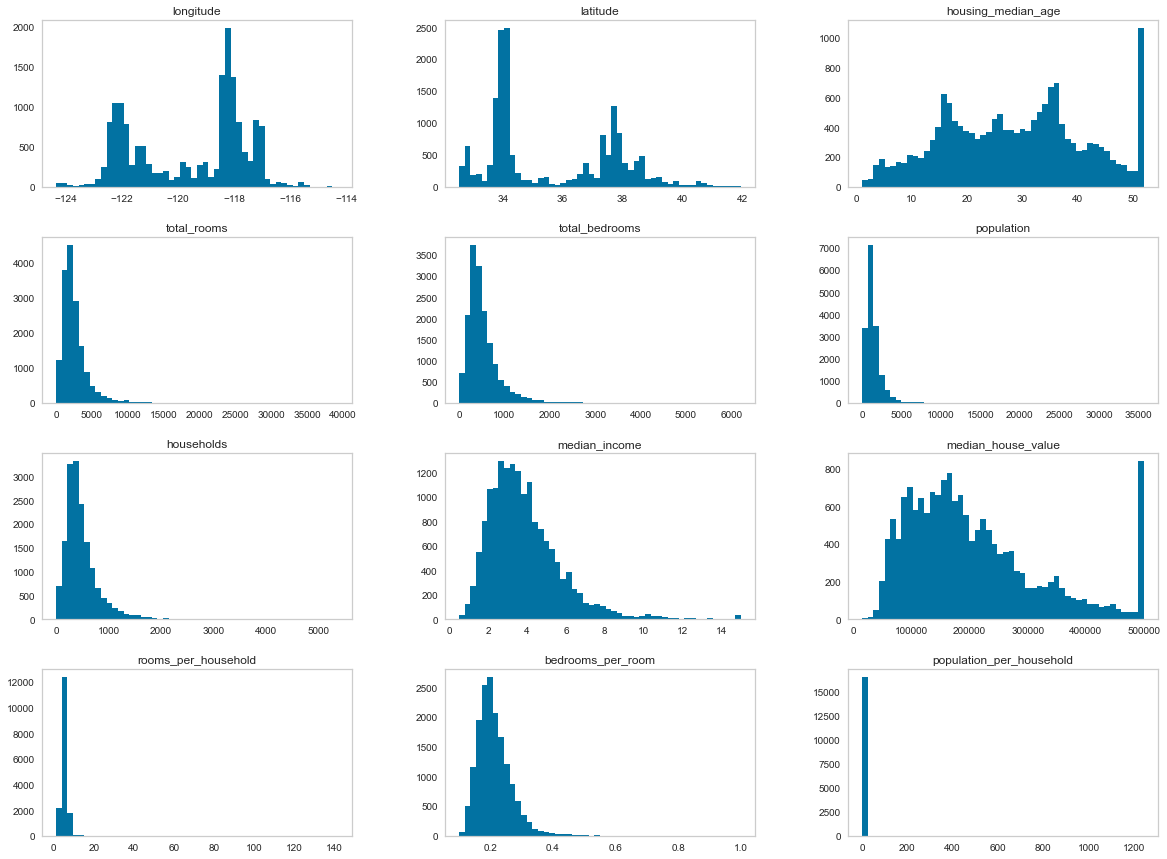

In [14]:
df_train.hist(bins=50, figsize=(20,15), grid=False)

In [104]:
skew_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household',
       'bedrooms_per_room', 'population_per_household']

for columns in skew_columns:
    skew = scipy.stats.skew(df_train[columns])
    kurtose = scipy.stats.kurtosis(df_train[columns])
    print(f'skewness of {columns} is {skew} and kurtosis is {kurtose}')

skewness of longitude is -0.29352874451469374 and kurtosis is -1.3346746104241525
skewness of latitude is 0.461413963730348 and kurtosis is -1.1172787727144196
skewness of housing_median_age is 0.05946271829705344 and kurtosis is -0.7969080364026646
skewness of total_rooms is 4.000472053692326 and kurtosis is 31.667075935827604
skewness of total_bedrooms is nan and kurtosis is nan
skewness of population is 4.741137582190821 and kurtosis is 71.76997617675471
skewness of households is 3.2217886135484464 and kurtosis is 19.28844744575096
skewness of median_income is 1.6532026643586635 and kurtosis is 4.93139857267446
skewness of median_house_value is 0.9867229628593513 and kurtosis is 0.3338328866664222
skewness of rooms_per_household is 21.420591570843328 and kurtosis is 879.184099463831
skewness of bedrooms_per_room is nan and kurtosis is nan
skewness of population_per_household is 87.92020947061515 and kurtosis is 8597.608876445469


we can see that it is a high concetration in the feature 'median_house_value' and 'housing_median_age' of the maximum value. Which suggests some distortion on the data set and probably this values were set to be the maximum and not beacuse it really is that.

In [105]:
df_train['median_house_value'].max()

500001.0

In [106]:
df_train[df_train['median_house_value'] == 500001.0]['median_house_value'].count()

786

although i would bet that is error in the data, i can't assume that from a public dataset that a i don't kknow how the dara was filled.

### 5.1.2 Categorical Features

TypeError: unsupported operand type(s) for -: 'str' and 'str'

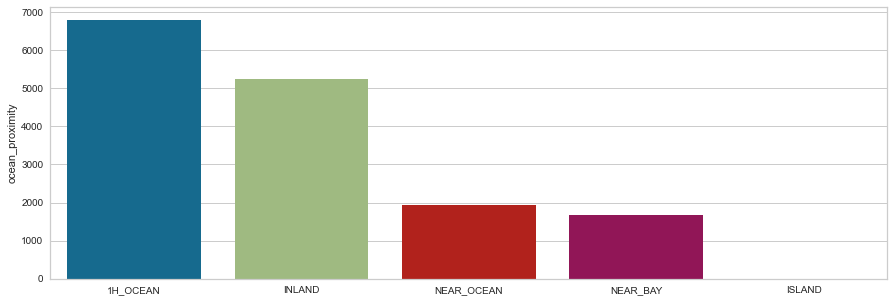

In [20]:
barplot(df_train['ocean_proximity'])

In [21]:
df_train[df_train['ocean_proximity'] == 'ISLAND']['ocean_proximity'].count()

2

## 5.2 Bivariate analysis

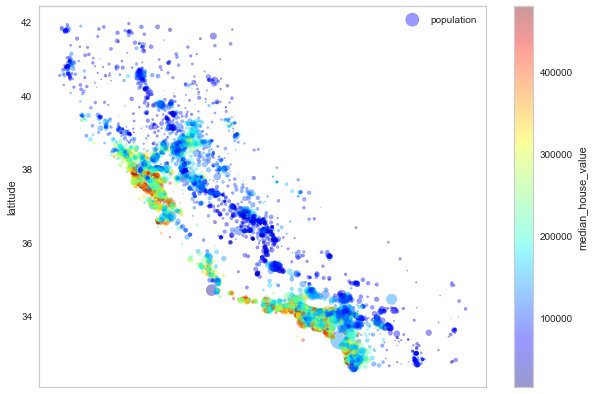

In [22]:
df_train.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,s=df_train['population']/100,
               label = 'population', figsize=(10,7), c='median_house_value',
              cmap=plt.get_cmap('jet'), colorbar=True
             )
plt.grid()
plt.legend()

<AxesSubplot:>

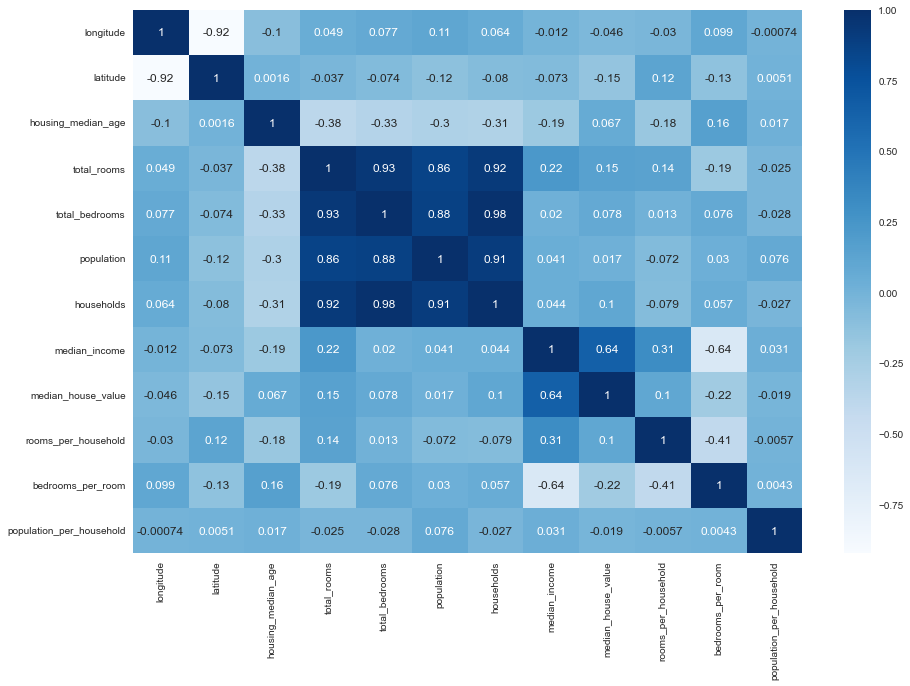

In [23]:
plt.figure(figsize = (15,10))
sns.heatmap(df_train.corr(), annot=True, cmap='Blues' )

# 6.0 Preprocessing

In [107]:
#Separate the train set
X_train = df_train.drop('median_house_value', axis = 1)
y_train = df_train['median_house_value'].copy()

## 6.1 Pipeline with yeo-johnson and standard scaler

In [108]:
#preprocessing train set with yeo-johnson standard scaler
X_train_num = X_train.drop('ocean_proximity', axis=1)

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('normal', PowerTransformer(method='yeo-johnson')),
                         ('standard_scaler', StandardScaler())
])

num_features = list(X_train_num)
cat_features = ['ocean_proximity']

full_pipeline = ColumnTransformer([('num', num_pipeline, num_features),
                                  ('cat', OneHotEncoder(), cat_features)
], verbose_feature_names_out=False)

X_train_prepared = pd.DataFrame(full_pipeline.fit_transform(X_train), columns=full_pipeline.get_feature_names_out())
X_train_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_1H_OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR_BAY,ocean_proximity_NEAR_OCEAN
0,-0.965127,1.287136,0.070886,0.870131,0.895882,0.978381,0.809682,-1.019164,0.247844,0.049837,0.481448,0.0,1.0,0.0,0.0,0.0
1,1.219183,-1.372245,-1.828157,1.397205,1.012909,0.806055,0.950363,1.303942,1.074168,-1.073231,-0.262430,0.0,0.0,0.0,0.0,1.0
2,0.207503,0.049539,1.193734,-0.403911,-0.513580,-0.778398,-0.469328,-0.428337,0.184801,-0.265511,-0.959358,0.0,1.0,0.0,0.0,0.0
3,1.288161,-1.639259,-0.325714,-0.203983,0.219187,-0.392081,0.209607,-0.969405,-1.100729,1.231901,-1.752183,0.0,0.0,0.0,0.0,1.0
4,0.391445,-0.558384,-0.086114,0.725610,0.556529,0.657074,0.492049,0.548577,0.630691,-0.480237,0.479876,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,1.311154,-1.418151,-1.170338,1.794284,1.649964,0.814927,1.412316,0.821959,0.939102,-0.430704,-1.371096,1.0,0.0,0.0,0.0,0.0
16508,-0.942134,1.284132,-1.081880,2.107206,1.916480,2.361913,2.066119,-0.474469,0.305244,-0.548498,0.704455,0.0,1.0,0.0,0.0,0.0
16509,-1.516953,1.262967,1.480122,-1.406928,-1.296601,-1.229355,-1.169056,-0.210713,-0.871467,0.604725,-0.202111,1.0,0.0,0.0,0.0,0.0
16510,-1.516953,1.223027,-1.170338,0.548626,0.388410,0.021205,0.265081,0.396467,0.745306,-0.451899,-0.613129,1.0,0.0,0.0,0.0,0.0


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>,
        <AxesSubplot:title={'center':'total_rooms'}>],
       [<AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>],
       [<AxesSubplot:title={'center':'rooms_per_household'}>,
        <AxesSubplot:title={'center':'bedrooms_per_room'}>,
        <AxesSubplot:title={'center':'population_per_household'}>,
        <AxesSubplot:title={'center':'ocean_proximity_1H_OCEAN'}>],
       [<AxesSubplot:title={'center':'ocean_proximity_INLAND'}>,
        <AxesSubplot:title={'center':'ocean_proximity_ISLAND'}>,
        <AxesSubplot:title={'center':'ocean_proximity_NEAR_BAY'}>,
        <AxesSubplot:title={'center':'ocean_proximity_NEAR_OCEAN'}>]],
      dtype=object)

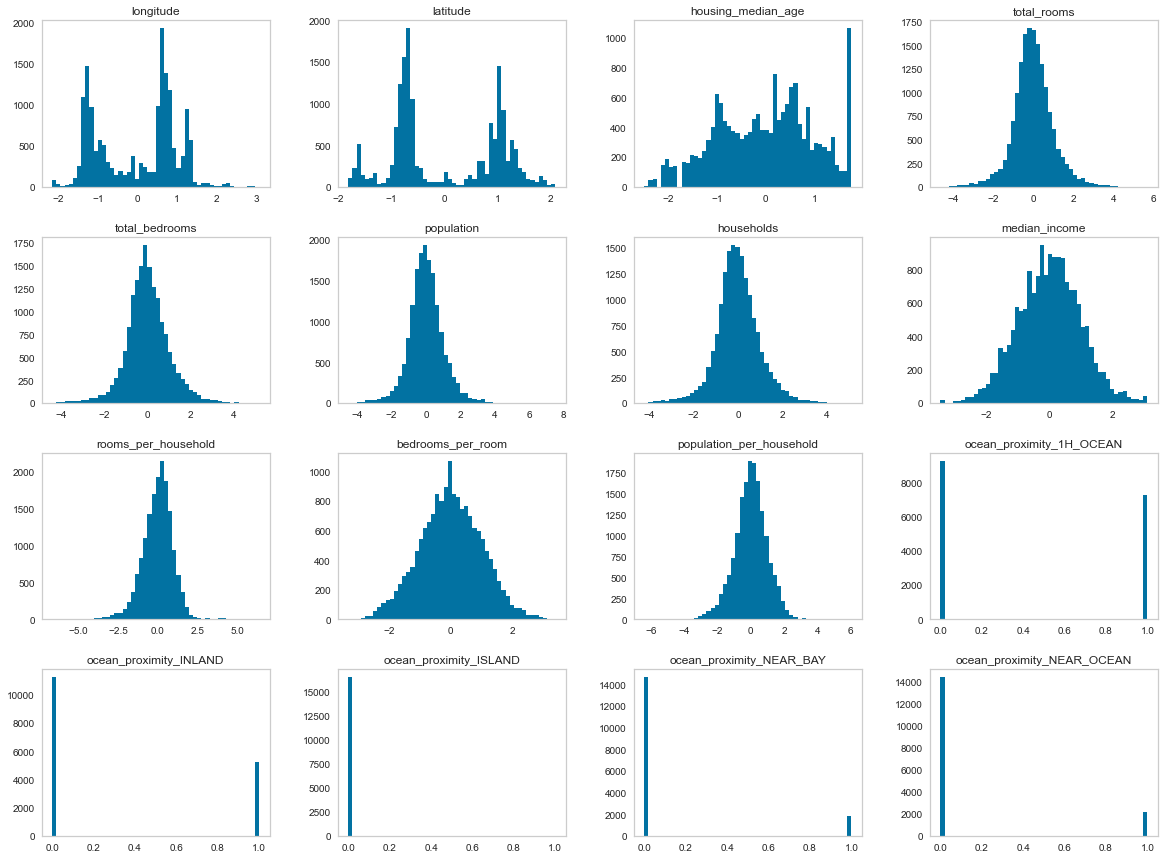

In [109]:
X_train_prepared.hist(bins=50, figsize=(20,15), grid=False)

## 6.2 Pipeline with min max scaler

In [110]:
#preprocessing train set with min max scaler
X_train_num_2 = X_train.drop('ocean_proximity', axis=1)

num_pipeline_2 = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('min_max_scaler', MinMaxScaler())
])

num_features_2 = list(X_train_num)
cat_features_2 = ['ocean_proximity']

full_pipeline_2 = ColumnTransformer([('num', num_pipeline_2, num_features_2),
                                  ('cat', OneHotEncoder(), cat_features_2)
], verbose_feature_names_out=False)

X_train_prepared_2 = pd.DataFrame(full_pipeline_2.fit_transform(X_train), columns=full_pipeline_2.get_feature_names_out())
X_train_prepared_2

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_1H_OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR_BAY,ocean_proximity_NEAR_OCEAN
0,0.287849,0.635494,0.549020,0.098362,0.128061,0.062614,0.131441,0.115426,0.030938,0.117537,0.001993,0.0,1.0,0.0,0.0,0.0
1,0.709163,0.058448,0.117647,0.135168,0.137403,0.056392,0.143017,0.402574,0.041176,0.067460,0.001554,0.0,0.0,0.0,0.0,1.0
2,0.528884,0.300744,0.843137,0.041003,0.049613,0.018610,0.055639,0.163798,0.030281,0.101772,0.001232,0.0,1.0,0.0,0.0,0.0
3,0.719124,0.022317,0.450980,0.047591,0.083280,0.025085,0.089806,0.119067,0.019575,0.196117,0.000939,0.0,0.0,0.0,0.0,1.0
4,0.562749,0.184910,0.509804,0.089790,0.103737,0.051403,0.107916,0.275617,0.035276,0.091880,0.001992,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.725100,0.052072,0.254902,0.169380,0.197970,0.056700,0.186520,0.316554,0.039267,0.094107,0.001072,1.0,0.0,0.0,0.0,0.0
16508,0.291833,0.634431,0.274510,0.200819,0.228737,0.133580,0.264376,0.159584,0.031550,0.088864,0.002149,0.0,1.0,0.0,0.0,0.0
16509,0.162351,0.626993,0.921569,0.017831,0.026418,0.012753,0.031740,0.184811,0.021168,0.149772,0.001586,1.0,0.0,0.0,0.0,0.0
16510,0.164343,0.613177,0.254902,0.080099,0.093106,0.033773,0.093167,0.254928,0.036703,0.093150,0.001383,1.0,0.0,0.0,0.0,0.0


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>,
        <AxesSubplot:title={'center':'total_rooms'}>],
       [<AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>],
       [<AxesSubplot:title={'center':'rooms_per_household'}>,
        <AxesSubplot:title={'center':'bedrooms_per_room'}>,
        <AxesSubplot:title={'center':'population_per_household'}>,
        <AxesSubplot:title={'center':'ocean_proximity_1H_OCEAN'}>],
       [<AxesSubplot:title={'center':'ocean_proximity_INLAND'}>,
        <AxesSubplot:title={'center':'ocean_proximity_ISLAND'}>,
        <AxesSubplot:title={'center':'ocean_proximity_NEAR_BAY'}>,
        <AxesSubplot:title={'center':'ocean_proximity_NEAR_OCEAN'}>]],
      dtype=object)

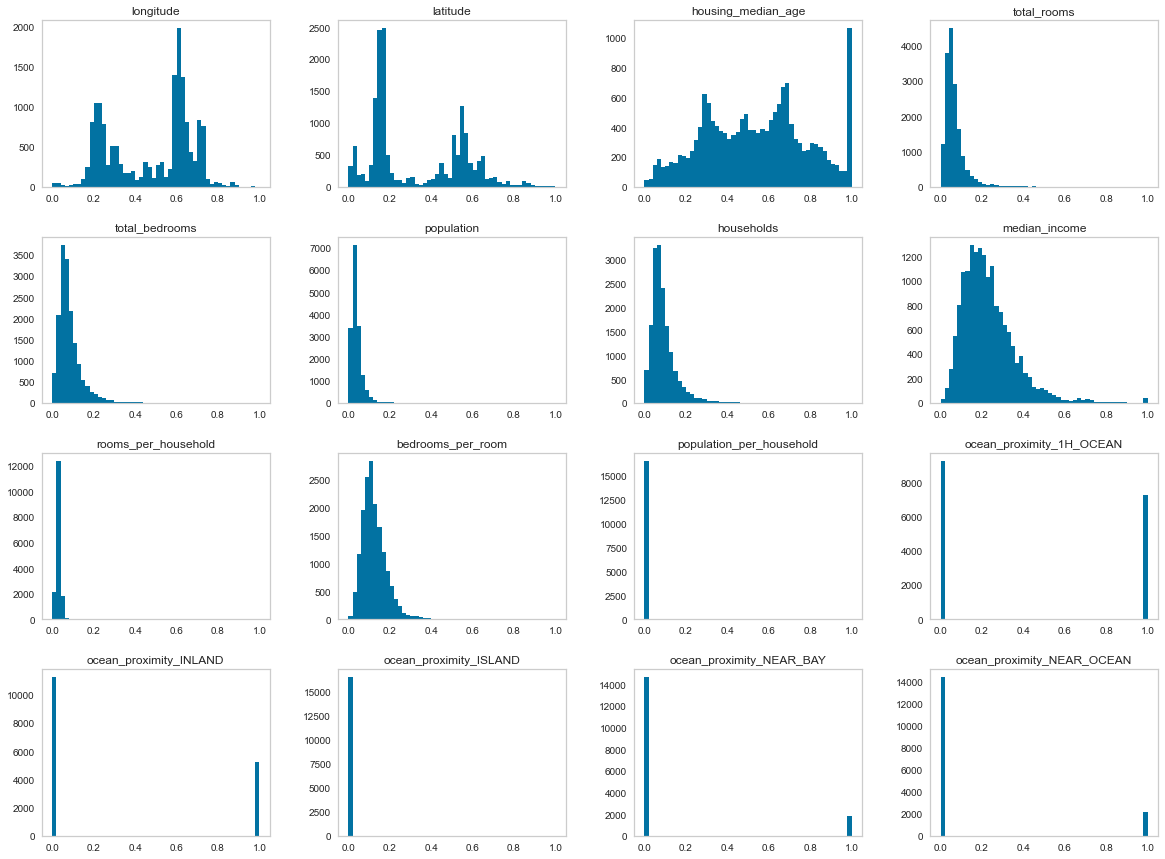

In [111]:
X_train_prepared_2.hist(bins=50, figsize=(20,15), grid=False)

## 6.3 Pipeline with robust scaler

In [129]:
#preprocessing train set with min max scaler
X_train_num_3 = X_train.drop('ocean_proximity', axis=1)

num_pipeline_3 = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('robust_scaler', RobustScaler())
])

num_features_3 = list(X_train_num)
cat_features_3 = ['ocean_proximity']

full_pipeline_3 = ColumnTransformer([('num', num_pipeline_3, num_features_3),
                                  ('cat', OneHotEncoder(), cat_features_3)
], verbose_feature_names_out=False)

X_train_prepared_3 = pd.DataFrame(full_pipeline_3.fit_transform(X_train), columns=full_pipeline_3.get_feature_names_out())
X_train_prepared_3

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_1H_OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR_BAY,ocean_proximity_NEAR_OCEAN
0,-0.778364,1.126984,0.000000,1.032980,1.055072,1.147594,0.922601,-0.627968,0.157041,0.043256,0.412784,0.0,1.0,0.0,0.0,0.0
1,0.337731,-0.309524,-1.157895,1.885159,1.223188,0.910160,1.114551,1.283411,1.049900,-0.663966,-0.228174,0.0,0.0,0.0,0.0,1.0
2,-0.139842,0.293651,0.789474,-0.295053,-0.356522,-0.531551,-0.334365,-0.305985,0.099735,-0.179397,-0.699153,0.0,1.0,0.0,0.0,0.0
3,0.364116,-0.399471,-0.263158,-0.142521,0.249275,-0.284492,0.232198,-0.603730,-0.833985,1.153007,-1.127496,0.0,0.0,0.0,0.0,1.0
4,-0.050132,0.005291,-0.105263,0.834511,0.617391,0.719786,0.532508,0.438331,0.535382,-0.319090,0.411238,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.379947,-0.325397,-0.789474,2.677267,2.313043,0.921925,1.835913,0.710828,0.883414,-0.287645,-0.933673,1.0,0.0,0.0,0.0,0.0
16508,-0.767810,1.124339,-0.736842,3.405183,2.866667,3.855615,3.126935,-0.334033,0.210378,-0.361695,0.641745,0.0,1.0,0.0,0.0,0.0
16509,-1.110818,1.105820,1.000000,-0.831567,-0.773913,-0.755080,-0.730650,-0.166110,-0.695008,0.498497,-0.182186,1.0,0.0,0.0,0.0,0.0
16510,-1.105541,1.071429,-0.789474,0.610130,0.426087,0.047059,0.287926,0.300614,0.659812,-0.301156,-0.478178,1.0,0.0,0.0,0.0,0.0


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>,
        <AxesSubplot:title={'center':'total_rooms'}>],
       [<AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>],
       [<AxesSubplot:title={'center':'rooms_per_household'}>,
        <AxesSubplot:title={'center':'bedrooms_per_room'}>,
        <AxesSubplot:title={'center':'population_per_household'}>,
        <AxesSubplot:title={'center':'ocean_proximity_1H_OCEAN'}>],
       [<AxesSubplot:title={'center':'ocean_proximity_INLAND'}>,
        <AxesSubplot:title={'center':'ocean_proximity_ISLAND'}>,
        <AxesSubplot:title={'center':'ocean_proximity_NEAR_BAY'}>,
        <AxesSubplot:title={'center':'ocean_proximity_NEAR_OCEAN'}>]],
      dtype=object)

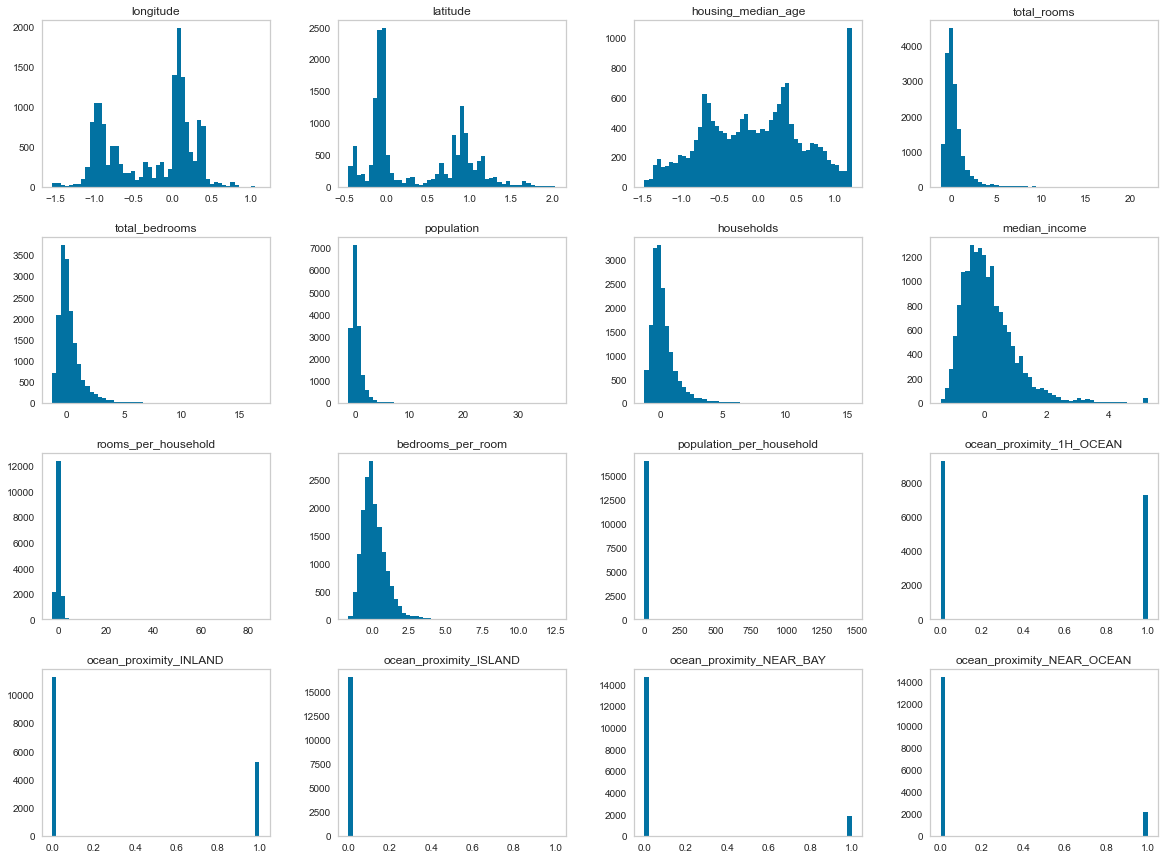

In [130]:
X_train_prepared_3.hist(bins=50, figsize=(20,15), grid=False)

# 7.0 Evaluation of Machine learning models

In [122]:
rfr = RandomForestRegressor()
etn = ElasticNet()
sgd = SGDRegressor()
svr = SVR()
xgb = xgb.XGBRegressor()

## 7.1 Evaluation with standard scaler and without target transformation

In [112]:
# Training and evaluating the models with cross-validation, standard scaler and without target transformation

model = {'Random Forest;Standard scaler;without target transform': rfr, 
         'ElasticNet;Standard scaler;without target transform': etn, 
         'Stochastic Gradient Descent;Standard scaler; without target transform': sgd,
         'Support Vector Regressor; Standard scaler; without target transform': svr, 
         'XGBoost;Standard scaler; without target transform': xgb}

df1 = pd.DataFrame(columns=['Model', 'Mean RMSE','Standard deviation'], index=[0])

for model_name, model in model.items():
    scores = cross_val_score(model, X_train_prepared, y_train, scoring='neg_root_mean_squared_error', cv=5)
    final_score = -scores
    dicionario = display_scores(model_name,final_score)
    df1 = df1.append(dicionario, ignore_index=True)

df1 = df1.drop(index=[0])
df1.reset_index(drop=True)
df1.sort_values(by=['Mean RMSE'], ascending=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\1790494783.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\1790494783.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\1790494783.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\1790494783.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(dicionario, ignore_index=True)


,Model,Mean RMSE,Standard deviation
5,XGBoost;Standard scaler; without target transform,47529.561004,1067.887104
1,Random Forest;Standard scaler;without target t...,50785.124303,795.924053
3,Stochastic Gradient Descent;Standard scaler; w...,70988.186109,607.845508
2,ElasticNet;Standard scaler;without target tran...,78548.95391,801.357021
4,Support Vector Regressor; Standard scaler; wit...,118623.456545,863.301832


## 7.2 Evaluation with standard scaler and target transformation

In [113]:
# Training and evaluating the models with cross-validation,standard scaler and target transformation

model = {'Random Forest;Standard scaler;with target transform': rfr, 
         'ElasticNet;Standard scaler;with target transform': etn, 
         'Stochastic Gradient Descent;Standard scaler;with target transform': sgd, 
         'Support Vector Regressor;Standard scaler;with target transform': svr, 
         'XGBoost;Standard scaler;with target transform': xgb}

df2 = pd.DataFrame(columns=['Model', 'Mean RMSE','Standard deviation'], index=[0])

for model_name, model in model.items():
    scores = cross_val_score(TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp),  
                                                          X_train_prepared, 
                                                          y_train,
                                                          scoring='neg_root_mean_squared_error', cv=5)
    final_score = -scores
    dicionario = display_scores(model_name,final_score)
    df2 = df2.append(dicionario, ignore_index=True)

df2 = df2.drop(index=[0])
df2.reset_index(drop=True)
df2.sort_values(by=['Mean RMSE'], ascending=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\2220729666.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\2220729666.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\2220729666.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\2220729666.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(dicionario, ignore_index=True)


,Model,Mean RMSE,Standard deviation
5,XGBoost;Standard scaler;with target transform,48212.216774,1048.721537
1,Random Forest;Standard scaler;with target tran...,51014.459556,887.770401
4,Support Vector Regressor;Standard scaler;with ...,54900.66568,721.21293
3,Stochastic Gradient Descent;Standard scaler;wi...,66682.681261,1383.289974
2,ElasticNet;Standard scaler;with target transform,119452.621967,841.761406


## 7.3 Evaluation with min max scaler and without target transformation

In [127]:
# Training and evaluating the models with cross-validation, min max scaler and without target transformation

model = {'Random Forest;Min Max Scaler;without target transform': rfr, 
         'ElasticNet;Min Max Scaler;without target transform': etn, 
         'Stochastic Gradient Descent;Min Max Scaler; without target transform': sgd,
         'Support Vector Regressor; Min Max Scaler; without target transform': svr, 
         'XGBoost;Min Max Scaler; without target transform': xgb}

df3 = pd.DataFrame(columns=['Model', 'Mean RMSE','Standard deviation'], index=[0])

for model_name, model in model.items():
    scores = cross_val_score(model, X_train_prepared_2, y_train, scoring='neg_root_mean_squared_error', cv=5)
    final_score = -scores
    dicionario = display_scores(model_name,final_score)
    df3 = df3.append(dicionario, ignore_index=True)

df3 = df3.drop(index=[0])
df3.reset_index(drop=True)
df3.sort_values(by=['Mean RMSE'], ascending=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\4007966488.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\4007966488.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\4007966488.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\4007966488.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(dicionario, ignore_index=True)


,Model,Mean RMSE,Standard deviation
5,XGBoost;Min Max Scaler; without target transform,47421.735903,971.323499
1,Random Forest;Min Max Scaler;without target tr...,50656.433334,803.45507
3,Stochastic Gradient Descent;Min Max Scaler; wi...,70235.080603,977.359032
2,ElasticNet;Min Max Scaler;without target trans...,105411.692016,594.231399
4,Support Vector Regressor; Min Max Scaler; with...,118420.778484,851.780538


## 7.4 Evaluation with min max scaler and target transformation

In [115]:
# Training and evaluating the models with cross-validation,min max scaler and target transformation

model = {'Random Forest;Min Max Scaler;with target transform': rfr, 
         'ElasticNet;Min Max Scaler;with target transform': etn, 
         'Stochastic Gradient Descent;Min Max Scaler;with target transform': sgd, 
         'Support Vector Regressor;Min Max Scaler;with target transform': svr, 
         'XGBoost;Min Max Scaler;with target transform': xgb}

df4 = pd.DataFrame(columns=['Model', 'Mean RMSE','Standard deviation'], index=[0])

for model_name, model in model.items():
    scores = cross_val_score(TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp),  
                                                          X_train_prepared_2, 
                                                          y_train,
                                                          scoring='neg_root_mean_squared_error', cv=5)
    final_score = -scores
    dicionario = display_scores(model_name,final_score)
    df4 = df4.append(dicionario, ignore_index=True)

df4 = df4.drop(index=[0])
df4.reset_index(drop=True)
df4.sort_values(by=['Mean RMSE'], ascending=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\652305030.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df4 = df4.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\652305030.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df4 = df4.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\652305030.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df4 = df4.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\652305030.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df4 = df4.append(dicionario, ignore_index=True)
C:\U

,Model,Mean RMSE,Standard deviation
5,XGBoost;Min Max Scaler;with target transform,47704.928099,1176.626258
1,Random Forest;Min Max Scaler;with target trans...,50726.167591,935.283555
4,Support Vector Regressor;Min Max Scaler;with t...,62057.261229,1327.411865
3,Stochastic Gradient Descent;Min Max Scaler;wit...,106229.232732,6506.139399
2,ElasticNet;Min Max Scaler;with target transform,119452.621967,841.761406


## 7.5 Evaluation with robust scaler and without target transformation

In [131]:
# Training and evaluating the models with cross-validation, robust scaler and without target transformation

model = {'Random Forest;Robust Scaler;without target transform': rfr, 
         'ElasticNet;Robust Scaler;without target transform': etn, 
         'Stochastic Gradient Descent;Robust Scaler; without target transform': sgd,
         'Support Vector Regressor; Robust Scaler; without target transform': svr, 
         'XGBoost;Robust Scaler; without target transform': xgb}

df5 = pd.DataFrame(columns=['Model', 'Mean RMSE','Standard deviation'], index=[0])

for model_name, model in model.items():
    scores = cross_val_score(model, X_train_prepared_3, y_train, scoring='neg_root_mean_squared_error', cv=5)
    final_score = -scores
    dicionario = display_scores(model_name,final_score)
    df5 = df5.append(dicionario, ignore_index=True)

df5 = df5.drop(index=[0])
df5.reset_index(drop=True)
df5.sort_values(by=['Mean RMSE'], ascending=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\2152857064.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df5 = df5.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\2152857064.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df5 = df5.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\2152857064.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df5 = df5.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\2152857064.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df5 = df5.append(dicionario, ignore_index=True)


,Model,Mean RMSE,Standard deviation
5,XGBoost;Robust Scaler; without target transform,47405.232728,992.549935
1,Random Forest;Robust Scaler;without target tra...,50505.966582,884.402789
2,ElasticNet;Robust Scaler;without target transform,80999.401639,778.730674
4,Support Vector Regressor; Robust Scaler; witho...,118861.372129,858.325771
3,Stochastic Gradient Descent;Robust Scaler; wit...,2293698824608.555176,2501923724883.54248


## 7.6 Evaluation with robust scaler and target transformation

In [132]:
# Training and evaluating the models with cross-validation,Robust Scaler and target transformation

model = {'Random Forest;Robust Scaler;with target transform': rfr, 
         'ElasticNet;Robust Scaler;with target transform': etn, 
         'Stochastic Gradient Descent;Robust Scaler;with target transform': sgd, 
         'Support Vector Regressor;Robust Scaler;with target transform': svr, 
         'XGBoost;Robust Scaler;with target transform': xgb}

df6 = pd.DataFrame(columns=['Model', 'Mean RMSE','Standard deviation'], index=[0])

for model_name, model in model.items():
    scores = cross_val_score(TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp),  
                                                          X_train_prepared_3, 
                                                          y_train,
                                                          scoring='neg_root_mean_squared_error', cv=5)
    final_score = -scores
    dicionario = display_scores(model_name,final_score)
    df6 = df6.append(dicionario, ignore_index=True)

df6 = df6.drop(index=[0])
df6.reset_index(drop=True)
df6.sort_values(by=['Mean RMSE'], ascending=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\801038644.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df6 = df6.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\801038644.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df6 = df6.append(dicionario, ignore_index=True)
C:\Users\Dell\Anaconda3\Anaconda\envs\Project Housing 2\lib\site-packages\sklearn\preprocessing\_function_transformer.py:292: RuntimeWarning: overflow encountered in exp
  return func(X, **(kw_args if kw_args else {}))
C:\Users\Dell\Anaconda3\Anaconda\envs\Project Housing 2\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\

C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\801038644.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df6 = df6.append(dicionario, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11632\801038644.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df6 = df6.append(dicionario, ignore_index=True)


,Model,Mean RMSE,Standard deviation
5,XGBoost;Robust Scaler;with target transform,47696.908677,1187.15409
1,Random Forest;Robust Scaler;with target transform,50810.755576,1107.471925
4,Support Vector Regressor;Robust Scaler;with ta...,62100.391255,1842.37427
2,ElasticNet;Robust Scaler;with target transform,119452.621967,841.761406
3,Stochastic Gradient Descent;Robust Scaler;with...,NaN,NaN


## 7.5 Final evaluation 

In [133]:
#concat dfs
evaluation = pd.concat([df1,df2,df3,df4,df5,df6], ignore_index=True)

#separate column "model" by ;
division = evaluation['Model'].str.split(';')

#get the values by the index position
model = division.str.get(0)
scaler = division.str.get(1)
target = division.str.get(2)

#atribute in the DF the values
evaluation['Model Name'] = model
evaluation['Scaler'] = scaler
evaluation['Target'] = target

#drop old column
evaluation.drop(['Model'], axis=1, inplace=True)

#reorder columns and ordey by rmse
evaluation = evaluation[['Model Name','Scaler','Target','Mean RMSE', 'Standard deviation']]
evaluation.reset_index(drop=True)
evaluation.sort_values(by=['Mean RMSE'], ascending=True)

,Model Name,Scaler,Target,Mean RMSE,Standard deviation
24,XGBoost,Robust Scaler,without target transform,47405.232728,992.549935
14,XGBoost,Min Max Scaler,without target transform,47421.735903,971.323499
4,XGBoost,Standard scaler,without target transform,47529.561004,1067.887104
29,XGBoost,Robust Scaler,with target transform,47696.908677,1187.15409
19,XGBoost,Min Max Scaler,with target transform,47704.928099,1176.626258
9,XGBoost,Standard scaler,with target transform,48212.216774,1048.721537
20,Random Forest,Robust Scaler,without target transform,50505.966582,884.402789
10,Random Forest,Min Max Scaler,without target transform,50656.433334,803.45507
15,Random Forest,Min Max Scaler,with target transform,50726.167591,935.283555
0,Random Forest,Standard scaler,without target transform,50785.124303,795.924053


As we can see, the best result was provide from XGBoost model

# 8.0 Feature Selection

KeyboardInterrupt: 

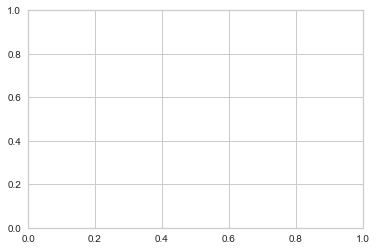

In [134]:
rfe = RFECV(xgb,cv=5, scoring='neg_root_mean_squared_error' )
rfe.fit(X_train_prepared_3, y_train)
rfe.poof()

In [67]:
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_feat = list(cat_encoder.categories_[0])
features = num_features + cat_one_hot_feat
list(zip(features,rfe.support_,rfe.ranking_))

[('longitude', True, 1),
 ('latitude', True, 1),
 ('housing_median_age', True, 1),
 ('total_rooms', True, 1),
 ('total_bedrooms', True, 1),
 ('population', False, 4),
 ('households', False, 2),
 ('median_income', True, 1),
 ('rooms_per_household', True, 1),
 ('bedrooms_per_room', True, 1),
 ('population_per_household', True, 1),
 ('1H_OCEAN', False, 3),
 ('INLAND', True, 1),
 ('ISLAND', False, 5),
 ('NEAR_BAY', True, 1),
 ('NEAR_OCEAN', True, 1)]

although the RFECV package has pointing 12 features as ideal, i optate to not exclude any feature because all the ones that was suggest to exclude or are use to derivate other features that are important or is associate to ocean proximity variables as 'Island'. Beyond that, the RMSE only increase 150 points, the main benefit would be make a easier deploy e more simple model, maybe later i'll try that. Lets see the final performance with the test set.

# 9.0 Hyperparameter fine-tuning

In [135]:
# new pipeline with drop of features

final_X_train_num = X_train.drop(['ocean_proximity'], axis=1)

final_num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('robust_scaler', RobustScaler())
])

final_num_features = list(final_X_train_num)
final_cat_features = ['ocean_proximity']

final_full_pipeline = ColumnTransformer([('num', final_num_pipeline, final_num_features),
                                      ('cat', OneHotEncoder(), final_cat_features)
], verbose_feature_names_out=False)

final_X_train_prepared = pd.DataFrame(final_full_pipeline.fit_transform(X_train), 
                                columns=final_full_pipeline.get_feature_names_out())
final_X_train_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_1H_OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR_BAY,ocean_proximity_NEAR_OCEAN
0,-0.778364,1.126984,0.000000,1.032980,1.055072,1.147594,0.922601,-0.627968,0.157041,0.043256,0.412784,0.0,1.0,0.0,0.0,0.0
1,0.337731,-0.309524,-1.157895,1.885159,1.223188,0.910160,1.114551,1.283411,1.049900,-0.663966,-0.228174,0.0,0.0,0.0,0.0,1.0
2,-0.139842,0.293651,0.789474,-0.295053,-0.356522,-0.531551,-0.334365,-0.305985,0.099735,-0.179397,-0.699153,0.0,1.0,0.0,0.0,0.0
3,0.364116,-0.399471,-0.263158,-0.142521,0.249275,-0.284492,0.232198,-0.603730,-0.833985,1.153007,-1.127496,0.0,0.0,0.0,0.0,1.0
4,-0.050132,0.005291,-0.105263,0.834511,0.617391,0.719786,0.532508,0.438331,0.535382,-0.319090,0.411238,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.379947,-0.325397,-0.789474,2.677267,2.313043,0.921925,1.835913,0.710828,0.883414,-0.287645,-0.933673,1.0,0.0,0.0,0.0,0.0
16508,-0.767810,1.124339,-0.736842,3.405183,2.866667,3.855615,3.126935,-0.334033,0.210378,-0.361695,0.641745,0.0,1.0,0.0,0.0,0.0
16509,-1.110818,1.105820,1.000000,-0.831567,-0.773913,-0.755080,-0.730650,-0.166110,-0.695008,0.498497,-0.182186,1.0,0.0,0.0,0.0,0.0
16510,-1.105541,1.071429,-0.789474,0.610130,0.426087,0.047059,0.287926,0.300614,0.659812,-0.301156,-0.478178,1.0,0.0,0.0,0.0,0.0


In [136]:
#hyperparameter fine-tuning with grid search
param_grid = [{'eta': [0.01, 0.03, 0.05], 'subsample': [0.3, 0.5, 0.7], 'max_depth':[5, 10],
               'n_estimators': [1500, 2500], 'random_state': [42]}]

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)

grid_search.fit(final_X_train_prepared, y_train)

print(grid_search.best_params_)

print(f'RMSE: {-grid_search.best_score_}')

grid_search.best_estimator_

{'eta': 0.03, 'max_depth': 5, 'n_estimators': 2500, 'random_state': 42, 'subsample': 0.7}
RMSE: 44998.64723498274


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.03,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0299999993, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2500,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, ...)

# 10.0 Final model

In [137]:
#Evaluate with the test set
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop(['median_house_value'], axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test['rooms_per_household'] = X_test['total_rooms']/X_test['households']
X_test['bedrooms_per_room'] = X_test['total_bedrooms']/X_test['total_rooms']
X_test['population_per_household'] = X_test['population']/X_test['households']

X_test_prepared = final_full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)

final_rmse = np.sqrt(final_mse)

final_mae = mean_absolute_error(y_test, final_predictions)

final_r2 = r2_score(y_test, final_predictions)

dicionario = {'RMSE': final_rmse, 'MAE': final_mae, 'R²': final_r2}
resultado = pd.DataFrame(dicionario, index=[0])
resultado

,RMSE,MAE,R²
0,42978.461679,28191.505917,0.858273


We reached a RMSE of 42.978 and the book had reacher an RMSE of 47.730, so the model has been improved solidly.

C:\Users\Dell\Anaconda3\Anaconda\envs\Project Housing 2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


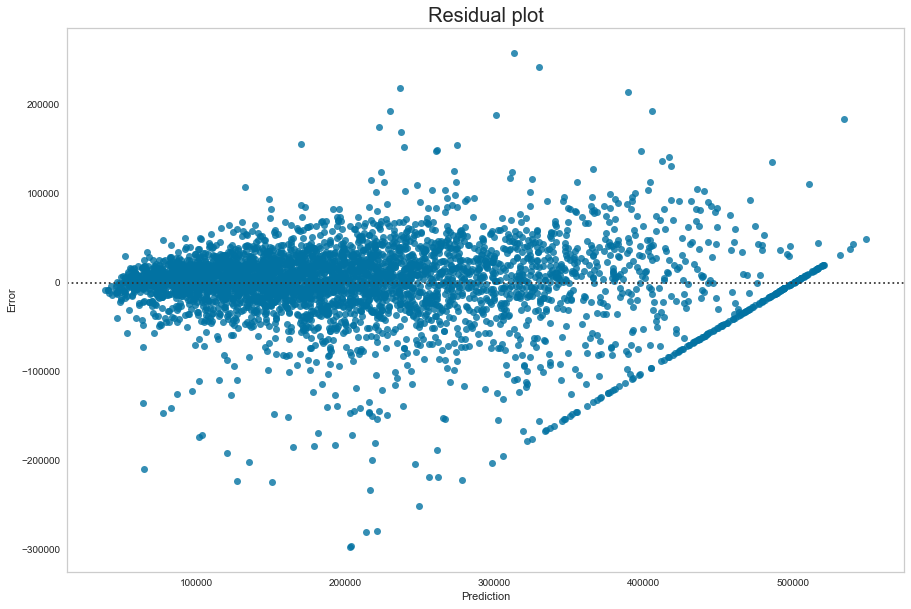

In [138]:
aux = pd.DataFrame( { 'y_test': y_test, 'Prediction': final_predictions,'Error': final_predictions - y_test} )
plt.figure(figsize=(15,10));
sns.residplot(aux['Prediction'], aux['Error']);
plt.title("Residual plot", fontsize=20);
plt.grid();

In [139]:
aux.sort_values(by='Error').head(20)

,y_test,Prediction,Error
15288,500001.0,203063.703125,-296937.296875
15303,500001.0,204129.812500,-295871.187500
6702,493200.0,213727.109375,-279472.890625
17858,500001.0,221227.328125,-278773.671875
4644,500001.0,249473.515625,-250527.484375
15635,450000.0,216930.687500,-233069.312500
987,375000.0,150752.781250,-224247.218750
4875,350000.0,127404.171875,-222595.828125
15652,500001.0,278535.281250,-221465.718750
4642,475000.0,256336.281250,-218663.718750


The biggest erros are concentrate when the values are "500.001", this corroborates a little with the hypothesis of the dataset had some errors when was filled.

# 10. Deploy

In [140]:
import joblib

In [141]:
data_train = X_train
data_train['median_house_value'] = y_train
data_train.to_csv('data_train.csv')

In [142]:
final_data_train = final_X_train_prepared
final_data_train['median_house_value'] = y_train
final_data_train.to_csv('final_data_train.csv')

In [143]:
joblib.dump(final_model, 'housing.joblib')

['housing.joblib']

In [145]:
joblib.dump(final_full_pipeline, 'pipe.joblib')

['pipe.joblib']